# Evaluation of subsystem 2 (gesture classifier)

In [3]:
from tensorflow.keras.models import load_model
from pickle import load,dump
from sklearn.model_selection import train_test_split
import numpy as np
import gestureClassification
from importlib import reload
reload(gestureClassification)
import plotly.express as px
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from time import time
from numpy.random import choice
from joblib import dump as jlDump, load as jlLoad

## MLP model

In [13]:
data = gestureClassification._concat_data()
X_train,X_val,X_test,y_train,y_val,y_test = gestureClassification._get_Xs_ys(data)

encoder = gestureClassification._get_label_encoder(y_train)

with open('models/encoder_reg.obj','wb') as f:
    dump(encoder,f)

y_train_encoded = gestureClassification._encode_labels(y_train,encoder)
y_val_encoded = gestureClassification._encode_labels(y_val,encoder)
y_test_encoded = gestureClassification._encode_labels(y_test,encoder)

model = gestureClassification._build_model()
history = gestureClassification._train_model(model,X_train,y_train_encoded,X_val,y_val_encoded)
model.save('models/mlp_reg')

Epoch 00022: early stopping

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/mlp_reg/assets


/Users/sprietthibault/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.

/Users/sprietthibault/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning:

`layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                2050      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 306       
Total params: 10,006
Trainable params: 10,006
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_df = pd.DataFrame(data=history.history)
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=("Loss monitoring", "Accuracy monitoring"))

fig.append_trace(go.Scatter(
    x=history_df.index,
    y=history_df["loss"],
    name='loss'
), row=1, col=1)
fig.append_trace(go.Scatter(
    x=history_df.index,
    y=history_df["val_loss"],
    name='val loss'
), row=1, col=1)
fig.append_trace(go.Scatter(
    x=history_df.index,
    y=history_df["categorical_accuracy"],
    name="accuracy"
), row=2, col=1)
fig.append_trace(go.Scatter(
    x=history_df.index,
    y=history_df["val_categorical_accuracy"],
    name="val accuracy"
), row=2, col=1)


fig.update_layout(height=600, width=900, title_text="Training and validation")
fig.update_xaxes(title_text="epoch", row=1, col=1)
fig.update_xaxes(title_text="epoch", row=2, col=1)
fig.update_yaxes(title_text="loss", row=1, col=1)
fig.update_yaxes(title_text="accuracy", row=2, col=1)
fig.show()

In [16]:
loss,acc = model.evaluate(X_test,y_test_encoded)
print(f"Model test summary :\n\taccuracy : {acc:.2f}\n\tloss : {loss:.2f}")

339/339 [==============================] - 0s 344us/step - loss: 2.7776 - categorical_accuracy: 0.8724
Model test summary :
	accuracy : 0.87
	loss : 2.78


## KNN classifier

In [17]:
knn = gestureClassification._get_KNN_clf(X_train,y_train)

In [18]:
jlDump(knn,'models/knn.obj')

['models/knn.obj']

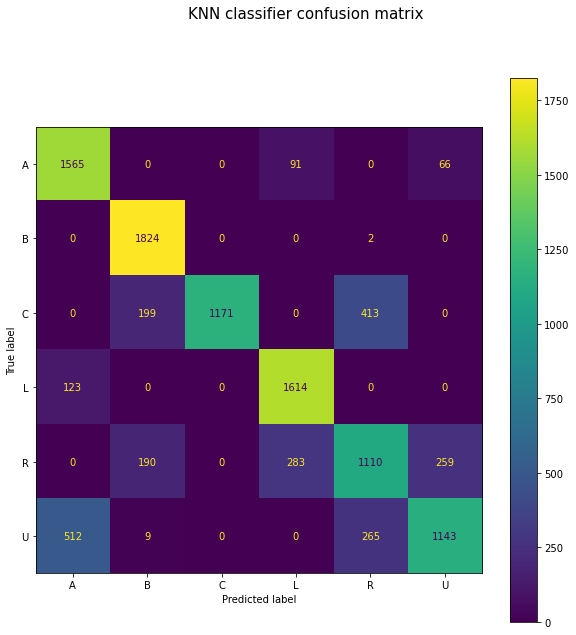

In [19]:
fig = plt.figure('confusion matrix',(10,10))
fig.suptitle('KNN classifier confusion matrix',size=15)
ax = plt.subplot(1,1,1)
ConfusionMatrixDisplay.from_predictions(y_test,knn.predict(X_test),display_labels=[label.split('_')[-1] for label in knn.classes_ ],ax=ax)

In [20]:
s = knn.score(X_test,y_test)
print(f"KNN accuracy : {s:.2f}")

KNN accuracy : 0.78


## Time complexity

In [21]:
mlp_times = []
knn_times = []

X_sample_idx = choice(X_test.shape[0],100,False)
for id in X_sample_idx:
    X = X_test[id]
    X = np.expand_dims(X,0)
    t_0 = time()
    _ = model.predict(X)
    t_1 = time()
    _ = knn.predict(X)
    t_2 = time()

    mlp_times.append(t_1-t_0)
    knn_times.append(t_2-t_1)

In [22]:
time_df = pd.DataFrame(data={'mlp':mlp_times,'knn':knn_times})
time_df.describe()

,mlp,knn
count,100.000000,100.000000
mean,0.013251,0.001562
std,0.006133,0.000201
min,0.011368,0.001367
25%,0.011898,0.001449
50%,0.012226,0.001494
75%,0.013144,0.001580
max,0.072897,0.002486
